<a href="https://colab.research.google.com/github/alexeiplatzer/unitree-go2-mjx-rl/blob/main/notebooks/colab_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup Runtime

In [ ]:
#@title Setup Runtime

# Install the correct Jax version with CUDA enabled
!pip install "jax[cuda12]==0.5.1"

build_madrona_backend = True #@param {"type":"boolean"}

if build_madrona_backend:
    # Install additional missing packages
    !sudo apt install -y libx11-dev libxrandr-dev libxinerama-dev libxcursor-dev libxi-dev mesa-common-dev

    # Get Madrona MJX and its subpackages
    !mkdir modules
    !git clone https://github.com/shacklettbp/madrona_mjx.git modules/madrona_mjx
    !git -C modules/madrona_mjx submodule update --init --recursive

    # Build Madrona MJX
    !mkdir modules/madrona_mjx/build
    !cd modules/madrona_mjx/build && cmake -DLOAD_VULKAN=OFF .. && make -j 8

    # Install Madrona MJX
    !pip install -e modules/madrona_mjx

# Clone and install our Quadruped RL package
!git clone https://github.com/alexeiplatzer/unitree-go2-mjx-rl.git
!pip install -e unitree-go2-mjx-rl

In [3]:
#@title Refresh the package
repo_path = "./unitree-go2-mjx-rl"
!git -C {repo_path} pull

remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 7 (delta 5), reused 7 (delta 5), pack-reused 0 (from 0)
Unpacking objects: 100% (7/7), 523 bytes | 261.00 KiB/s, done.
From https://github.com/alexeiplatzer/unitree-go2-mjx-rl
   49b9987..aa74193  main       -> origin/main
Updating 49b9987..aa74193
Fast-forward
 src/quadruped_mjx_rl/environments/quadruped/joystick_base.py | 2 +-
 1 file changed, 1 insertion(+), 1 deletion(-)


### Session Setup

INFO:root:Logging switched on.


Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl


INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


""

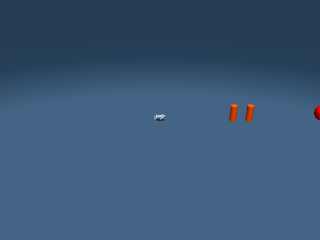

INFO:root:16
INFO:2025-09-21 19:53:19,066:jax._src.xla_bridge:924: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-09-21 19:53:19,080:jax._src.xla_bridge:924: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.


In [1]:
#@title Setup Session

# Configure logging
import logging
logging.basicConfig(level=logging.INFO, force=True)
logging.info("Logging switched on.")

import os
# Ensure that Madrona gets the chance to pre-allocate memory before Jax
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# On your second reading, load the compiled rendering backend to save time!
use_madrona_cache = False #@param {"type":"boolean"}
if use_madrona_cache:
    os.environ["MADRONA_MWGPU_KERNEL_CACHE"] = "modules/madrona_mjx/build/cache"

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
        "file_format_version" : "1.0.0",
        "ICD" : {
            "library_path" : "libEGL_nvidia.so.0"
        }
    }
    """)

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Tell XLA to use Triton GEMM, this improves steps/sec by ~30% on some GPUs
xla_flags = os.environ.get('XLA_FLAGS', '')
xla_flags += ' --xla_gpu_triton_gemm_any=True'
os.environ['XLA_FLAGS'] = xla_flags

# More legible printing from numpy.
import numpy as np
np.set_printoptions(precision=3, suppress=True, linewidth=100)

# Prepare paths
from etils.epath import Path
repo_path = Path("unitree-go2-mjx-rl")
scenes_path = repo_path / "resources" / "unitree_go2"
results_path = Path("results")
results_path.mkdir(parents=True, exist_ok=True)

# Prepare configs
from quadruped_mjx_rl.robots import predefined_robot_configs
robot_config = predefined_robot_configs["unitree_go2"]()

from quadruped_mjx_rl.environments import EnvironmentConfig
env_config_key = "QuadrupedVision" #@param ["QuadrupedVision", "QuadrupedVisionTarget"]
env_config_class = EnvironmentConfig.get_config_class_from_key(env_config_key)
use_vision = True #@param {"type":"boolean"}
env_config = env_config_class(use_vision=use_vision)

from quadruped_mjx_rl import models
model_architecture = "TeacherStudentVision" #@param ["ActorCritic","TeacherStudent","TeacherStudentVision"]
#@markdown ---
#@markdown **Model hyperparameters for the Actor-Critic Architecture**
if model_architecture == "ActorCritic":
    policy_layers = [128, 128, 128, 128, 128] # @param
    value_layers = [256, 256, 256, 256, 256] # @param

    model_config_class = models.ActorCriticConfig
    model_config = model_config_class(
        modules=model_config_class.ModulesConfig(
            policy=policy_layers,
            value=value_layers,
        ),
    )
#@markdown ---
#@markdown **Model hyperparameters for the Teacher-Student Architecture**
if model_architecture == "TeacherStudent":
    policy_layers = [256, 256, 256] #@param
    value_layers = [256, 256, 256] #@param
    teacher_encoder_layers = [256, 256] #@param
    student_encoder_layers = [256, 256] #@param
    latent_representation_size = 64 # @param {"type":"integer"}

    model_config_class = models.TeacherStudentConfig
    model_config = model_config_class(
        modules=model_config_class.ModulesConfig(
            policy=policy_layers,
            value=value_layers,
            encoder=teacher_encoder_layers,
            adapter=student_encoder_layers,
        ),
        latent_size=latent_representation_size,
    )
#@markdown ---
#@markdown **Model hyperparameters for the Teacher-Student-Vision Architecture**
if model_architecture == "TeacherStudentVision":
    policy_layers = [128, 128] #@param
    value_layers = [256, 256] #@param
    teacher_encoder_convolutional_layers = [4, 8, 16] #@param
    teacher_encoder_dense_layers = [256] #@param
    student_encoder_convolutional_layers = [4, 8, 16] #@param
    student_encoder_dense_layers = [256] #@param
    latent_representation_size = 128 #@param {"type":"integer"}

    model_config_class = models.TeacherStudentVisionConfig
    model_config = model_config_class(
        modules=model_config_class.ModulesConfig(
            policy=policy_layers,
            value=value_layers,
            encoder_convolutional=teacher_encoder_convolutional_layers,
            encoder_dense=teacher_encoder_dense_layers,
            adapter_convolutional=student_encoder_convolutional_layers,
            adapter_dense=student_encoder_dense_layers,
        ),
        latent_size=latent_representation_size,
    )

from quadruped_mjx_rl.training import configs as training_configs
#@markdown ---
#@markdown **PPO Hyperparameters**
discounting = 0.97 #@param {"type":"number"}
entropy_cost = 0.01 #@param {"type":"number"}
clipping_epsilon = 0.3 #@param {"type":"number"}
gae_lambda = 0.95 #@param {"type":"number"}
normalize_advantage = True #@param {"type":"boolean"}
reward_scaling = 1 #@param {"type":"integer"}
learning_rate = 0.0004 #@param {"type":"number"}
ppo_hyperparams = training_configs.HyperparamsPPO(
    discounting=discounting,
    entropy_cost=entropy_cost,
    clipping_epsilon=clipping_epsilon,
    gae_lambda=gae_lambda,
    normalize_advantage=normalize_advantage,
)
#@markdown **Teacher-Student specific hyperparameters**
#@markdown ---
if model_architecture == "TeacherStudent" or model_architecture == "TeacherStudentVision":
    student_learning_rate = 0.001 #@param {"type":"number"}
    max_grad_norm = 1.0 #@param
    optimizer_config = training_configs.TeacherStudentOptimizerConfig(
        learning_rate=learning_rate,
        student_learning_rate=student_learning_rate,
        max_grad_norm=max_grad_norm,
    )
else:
    optimizer_config = training_configs.OptimizerConfig(learning_rate=learning_rate)
#@markdown ---
#@markdown **Training hyperparameters without vision**
if model_architecture == "ActorCritic" or model_architecture == "TeacherStudent":
    num_envs = 128 #@param {"type":"integer"}
    num_eval_envs = 128 #@param {"type":"integer"}
    seed = 0 #@param {"type":"integer"}
    num_timesteps = 1_000_000 #@param {"type":"integer"}
    num_evals = 5 #@param {"type":"integer"}
    deterministic_eval = False #@param {"type":"boolean"}
    num_resets_per_eval = 0 #@param {"type":"integer"}
    episode_length = 1000 #@param {"type":"integer"}
    unroll_length = 20 #@param {"type":"integer"}
    normalize_observations = True  #@param {"type":"boolean"}
    action_repeat = 1 #@param {"type":"integer"}
    batch_size = 16 #@param {"type":"integer"}
    num_updates_per_batch = 8 #@param {"type":"integer"}
    num_minibatches = 16 #@param {"type":"integer"}
    training_config = training_configs.TrainingConfig(
        num_envs=num_envs,
        num_eval_envs=num_eval_envs,
        seed=seed,
        num_timesteps=num_timesteps,
        num_evals=num_evals,
        deterministic_eval=deterministic_eval,
        num_resets_per_eval=num_resets_per_eval,
        episode_length=episode_length,
        unroll_length=unroll_length,
        normalize_observations=normalize_observations,
        action_repeat=action_repeat,
        batch_size=batch_size,
        num_updates_per_batch=num_updates_per_batch,
        num_minibatches=num_minibatches,
        rl_hyperparams=ppo_hyperparams,
        optimizer=optimizer_config
    )
    vision_config = None
#@markdown ---
#@markdown **Training hyperparameters with vision**
elif model_architecture == "TeacherStudentVision":
    num_envs = 256 #@param {"type":"integer"}
    num_eval_envs = 256 #@param {"type":"integer"}
    seed = 0 #@param {"type":"integer"}
    num_timesteps = 1_000_000 #@param {"type":"integer"}
    num_evals = 5 #@param {"type":"integer"}
    deterministic_eval = False #@param {"type":"boolean"}
    num_resets_per_eval = 0 #@param {"type":"integer"}
    episode_length = 1000 #@param {"type":"integer"}
    unroll_length = 20 #@param {"type":"integer"}
    normalize_observations = True  #@param {"type":"boolean"}
    action_repeat = 1
    batch_size = 16 #@param {"type":"integer"}
    num_updates_per_batch = 8 #@param {"type":"integer"}
    num_minibatches = 16 #@param {"type":"integer"}
    training_config = training_configs.TrainingWithVisionConfig(
        num_envs=num_envs,
        num_eval_envs=num_eval_envs,
        seed=seed,
        num_timesteps=num_timesteps,
        num_evals=num_evals,
        deterministic_eval=deterministic_eval,
        num_resets_per_eval=num_resets_per_eval,
        episode_length=episode_length,
        unroll_length=unroll_length,
        normalize_observations=normalize_observations,
        action_repeat=action_repeat,
        batch_size=batch_size,
        num_updates_per_batch=num_updates_per_batch,
        num_minibatches=num_minibatches,
        rl_hyperparams=ppo_hyperparams,
        optimizer=optimizer_config,
    )
#@markdown **Vision renderer parameters**
    from quadruped_mjx_rl.robotic_vision import VisionConfig
    enabled_cameras=[1, 2] # @param
    enabled_geom_groups=[0, 1, 2] # @param
    render_width=64 #@param {"type":"integer"}
    render_height=64 #@param {"type":"integer"}
    vision_config = VisionConfig(
        render_batch_size=training_config.num_envs,
        enabled_cameras=enabled_cameras,
        enabled_geom_groups=enabled_geom_groups,
        render_width=render_width,
        render_height=render_height,
    )
else:
    raise NotImplementedError


# Set up the terrain
init_scene_path = scenes_path / "scene_mjx_cylinders.xml"

from quadruped_mjx_rl.terrain_gen import make_simple_obstacle_terrain, make_empty_terrain
env_model = make_empty_terrain(init_scene_path)

# Render the situation
import mujoco
from quadruped_mjx_rl.environments.rendering import render_model, show_image, large_overview_camera
image = render_model(env_model, initial_keyframe=robot_config.initial_keyframe, camera=large_overview_camera())
show_image(image)
#TODO add different images to see whats going on

# Craft the env factory
from quadruped_mjx_rl.environments import get_env_factory
from quadruped_mjx_rl.robotic_vision import get_renderer
import functools
from jax import numpy as jnp

renderer_maker = functools.partial(get_renderer, vision_config=vision_config, debug=False)
env_factory = get_env_factory(
    robot_config=robot_config,
    environment_config=env_config,
    env_model=env_model,
    customize_model=True,
    vision_config=vision_config,
    renderer_maker=renderer_maker,
)
#TODO add support for non vision envs with a metafactory
logging.info(training_config.batch_size)

from mujoco import mjx
mjx_model = mjx.put_model(env_model)
mjx_data = mjx.make_data(mjx_model)
# mjx_data = mjx_data.replace(qpos=jnp.array(init_qpos))
mjx_data = mjx.forward(mjx_model, mjx_data)



### Train

INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.


Setup finished, initializing the environment...


INFO:root:Params restored, starting training...
INFO:root:Device count: 1, process count: 1 (id 0), local device count: 1, devices to be used count: 1
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.


Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually
Inferred batch not found, overriding manually


INFO:root:observation size: {'pixels/view_frontal_ego': (64, 64, 3), 'pixels/view_terrain': (64, 64, 1), 'state': (420,), 'latent': (128,)}
INFO:root:observation size: {'pixels/view_frontal_ego': (64, 64, 3), 'pixels/view_terrain': (64, 64, 1), 'state': (420,), 'latent': (128,)}
INFO:root:observation size: {'pixels/view_frontal_ego': (64, 64, 3), 'pixels/view_terrain': (64, 64, 1), 'state': (420,), 'latent': (128,)}
INFO:root:observation size: {'pixels/view_frontal_ego': (64, 64, 3), 'pixels/view_terrain': (64, 64, 1), 'state': (420,), 'latent': (128,)}
INFO:root:Agent params type: <class 'quadruped_mjx_rl.models.architectures.guided_actor_critic.TeacherStudentAgentParams'>


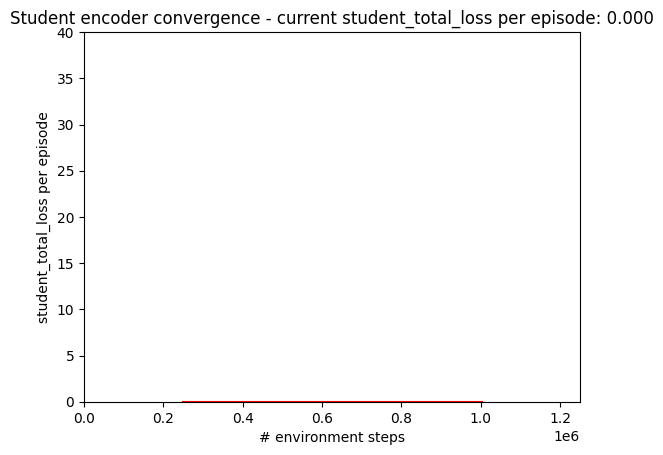

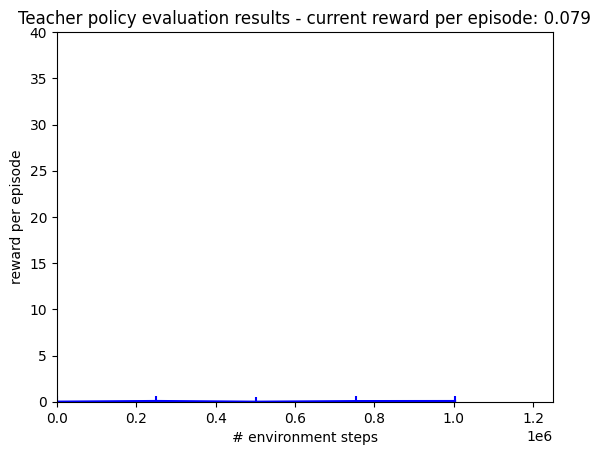

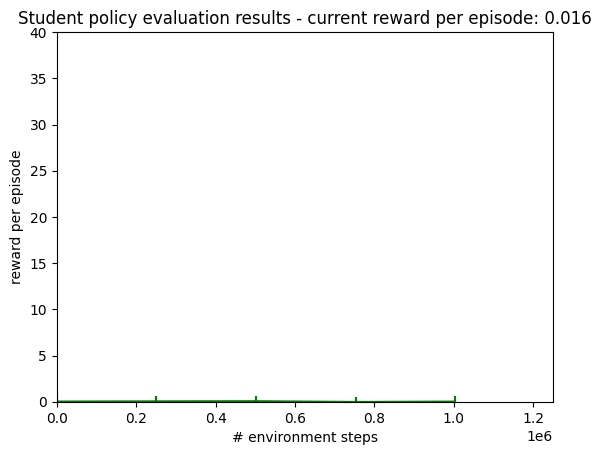

INFO:root:Setup took 74.36568832397461
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root:eval/episode_reward: 0.011222811
INFO:root:eval/episode_reward_std: 0.6351053
INFO:root:current_step: 0
INFO:root:Using JAX default device: cuda:0.
INFO:root:MJX Warp is disabled via MJX_WARP_ENABLED=false.
INFO:root:eval/episode_reward: 0.019338869
INFO:root:eval/episode_reward_std: 0.94682926
INFO:root:current_step: 0
INFO:root:student absolute loss: not known yet
INFO:root:starting iteration 0 326.5099322795868
INFO:root:training_metrics: {'training/sps': np.float64(1035.3030358380931), 'training/walltime': 242.32518529891968, 'training/entropy_loss': Array(-0.067, dtype=float32), 'training/policy_loss': Array(0.012, dtype=float32), 'training/student_total_loss': Array(0., dtype=float32), 'training/total_loss': Array(-0.036, dtype=float32), 'training/v_loss': Array(0.019, dtype=float32)}
INFO:root:eval/episode_reward: 0.08217861
INFO

In [2]:
#@title Train
# Create the environment
print("Setup finished, initializing the environment...")
env = env_factory()

# Checkpointing
from quadruped_mjx_rl.models.io import save_params, load_params
restore_params = False #@param {"type":"boolean"}
result_params_name = "resulting_params" #@param {"type":"string"}
if restore_params
    restored_params = load_params(results_path / result_params_name)
    logging.info("Params restored.")

# Try to launch a vision policy training
from quadruped_mjx_rl.training.train_interface import train
from quadruped_mjx_rl.domain_randomization.randomized_obstacles import terrain_randomize
params = train(
    training_config=training_config,
    model_config=model_config,
    training_env=env,
    evaluation_env=None,
    #randomization_fn=functools.partial(terrain_randomize, mj_model=env_model)
    restore_params=restored_params if restore_params else None,
)

save_params(results_path / result_params_name, params)